In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from google.colab import files
import io
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns

uploaded = files.upload()

Saving IMDB.csv to IMDB.csv


# IMDB Dataset

In [2]:
df = pd.read_csv(io.BytesIO(uploaded['IMDB.csv']))
print(df)

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


# Data Visualization

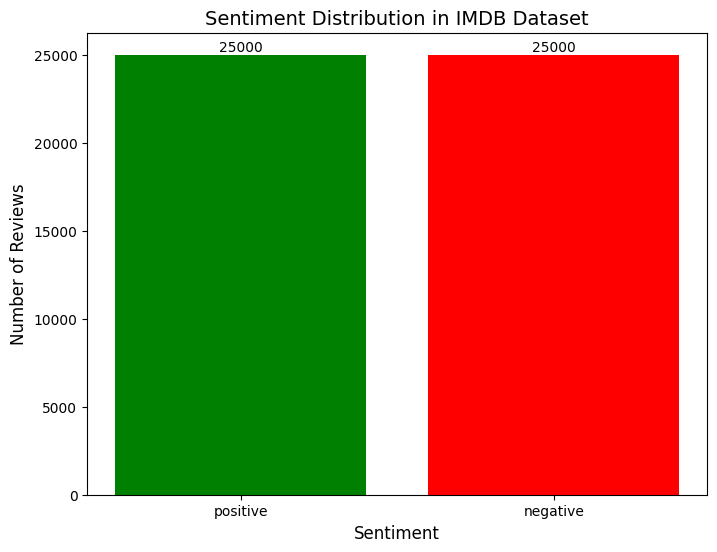

In [3]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))

bars = plt.bar(sentiment_counts.index, sentiment_counts.values,
               color=['green', 'red']) # Plot the class distribution in sentiment

plt.title('Sentiment Distribution in IMDB Dataset', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)


for bar in bars:
  height = bar.get_height()
  plt.text(bar.get_x() + bar.get_width() / 2, height,
           height, ha='center', va='bottom')

plt.show()

# Data Preprocessing

In [4]:
def clean_text(text):
  text = re.sub('<[^>]*>', '', text)     # remove tags
  text = re.sub('[^a-zA-Z]', ' ', text) # only keep letters
  text = text.lower()
  return text.split() # split text into tokens

df['review'] = df['review'].apply(clean_text)
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0) # convert sentiment to binary
print(df)

# Split into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Build vocabulary from training data
word_counts = Counter()
for tokens in train_df['review']:
    word_counts.update(tokens)

vocab = {'<pad>': 0, '<unk>': 1}
for word, count in word_counts.most_common(10000):  # Keep top most common
    vocab[word] = len(vocab)

max_length = 200  # Maximum sequence length for padding/truncating

def tokenize_and_pad(tokens):
    indices = [vocab.get(token, 1) for token in tokens]
    if len(indices) >= max_length:
        return indices[:max_length] # Truncating
    else:
        return indices + [0] * (max_length - len(indices))  # Padding

# Applying tokenization and padding on train and test sets
train_indices = [tokenize_and_pad(tokens) for tokens in train_df['review']]
test_indices = [tokenize_and_pad(tokens) for tokens in test_df['review']]

                                                  review  sentiment
0      [one, of, the, other, reviewers, has, mentione...          1
1      [a, wonderful, little, production, the, filmin...          1
2      [i, thought, this, was, a, wonderful, way, to,...          1
3      [basically, there, s, a, family, where, a, lit...          0
4      [petter, mattei, s, love, in, the, time, of, m...          1
...                                                  ...        ...
49995  [i, thought, this, movie, did, a, down, right,...          1
49996  [bad, plot, bad, dialogue, bad, acting, idioti...          0
49997  [i, am, a, catholic, taught, in, parochial, el...          0
49998  [i, m, going, to, have, to, disagree, with, th...          0
49999  [no, one, expects, the, star, trek, movies, to...          0

[50000 rows x 2 columns]


In [5]:
# Convert to tensors
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]

train_dataset = IMDBDataset(train_indices, train_df['sentiment'].values)
test_dataset = IMDBDataset(test_indices, test_df['sentiment'].values)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# LSTM Model

In [6]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded)
        out = output[:, -1, :]  # Last timestep output
        out = self.dropout(out)
        return torch.sigmoid(self.fc(out))

In [7]:
device = torch.device("cuda")

# Hyperparameters
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2
dropout = 0.5

model = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

SentimentLSTM(
  (embedding): Embedding(10002, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

# Training and Testing

In [9]:
num_epochs = 12
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    epoch_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')



Epoch 1, Loss: 0.6936
Epoch 2, Loss: 0.6912
Epoch 3, Loss: 0.6896
Epoch 4, Loss: 0.6927
Epoch 5, Loss: 0.6906
Epoch 6, Loss: 0.6877
Epoch 7, Loss: 0.6778
Epoch 8, Loss: 0.5362
Epoch 9, Loss: 0.4614
Epoch 10, Loss: 0.3988
Epoch 11, Loss: 0.3665
Epoch 12, Loss: 0.3673


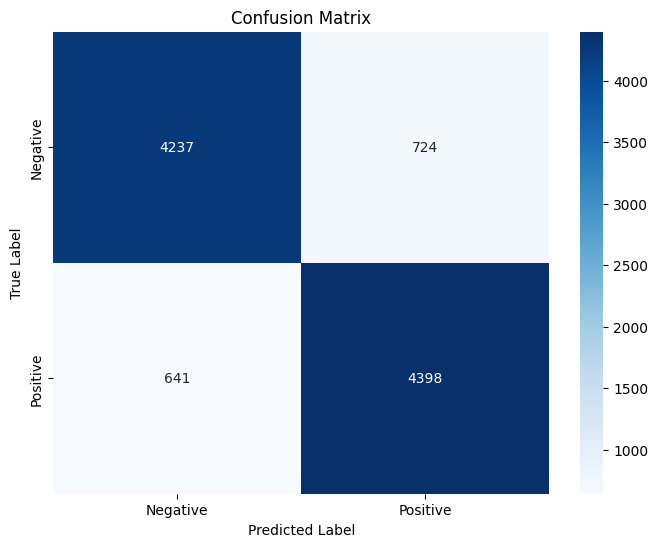

In [10]:
model.eval()
y_true = []
y_probs = []
y_pred = []

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs).squeeze(1)
    predicted = (outputs >= 0.5).float()
    y_true.extend(labels.cpu().numpy())
    y_probs.extend(outputs.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())


# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

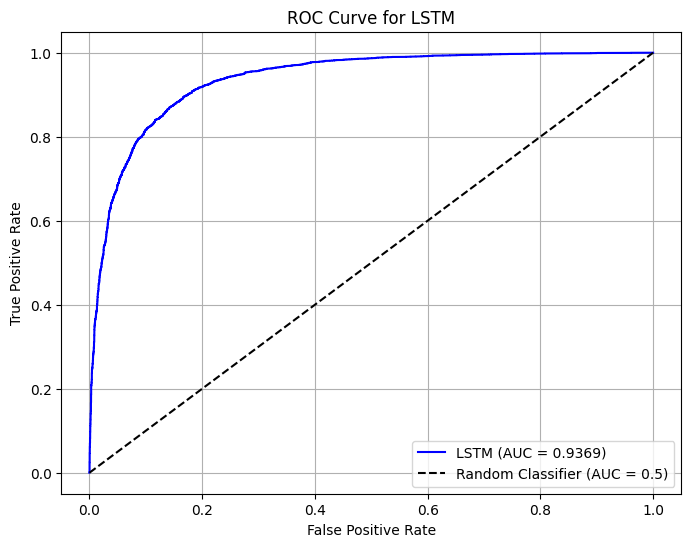

In [11]:

# Calculate auc score
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'LSTM (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve for LSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Predict custom reviews

In [12]:
def predict_custom(review_text):
    tokens = clean_text(review_text)
    indexed = tokenize_and_pad(tokens)

    # Convert to tensor
    tensor = torch.LongTensor(indexed).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(tensor).squeeze()
        prob = output.item()
    return "Positive" if prob >= 0.5 else "Negative", prob

# Short reviews

review = """This movie blew me away. The cinematography was stunning
and the story kept me engaged from start to finish."""

sentiment, confidence = predict_custom(review)
print(f"Prediction: {sentiment} | Confidence: {confidence:.4f}")

review = """A tedious and poorly-executed film. The dialogue felt forced
and the characters were utterly forgettable."""

sentiment, confidence = predict_custom(review)
print(f"Prediction: {sentiment} | Confidence: {confidence:.4f}")

Prediction: Positive | Confidence: 0.9609
Prediction: Negative | Confidence: 0.0200


In [13]:
# Long reviews

# Positive
review = """A rare example of an original film that’s also a crowd pleaser,
it’s another victory for one of the industry’s most industrious director-star duos.
Sinners is not just one of the best installments of the new “Vampire Renaissance”
but one of the best installments of the vampire mythos and perhaps the best film of his illustrious career."""

sentiment, confidence = predict_custom(review)
print(f"Prediction: {sentiment} | Confidence: {confidence:.4f}")

# Negative
review = """Snow White has a few nice touches, but the film feels misguided, miscalibrated,
and obviously reworked in post. Torn between staying faithful to the original or reimagining it,
it leaves us with the worst of both worlds. Because of how utterly incongruous its direction is,
it just ends up being a very confusing experience no matter your expectations."""

sentiment, confidence = predict_custom(review)
print(f"Prediction: {sentiment} | Confidence: {confidence:.4f}")

Prediction: Positive | Confidence: 0.9200
Prediction: Negative | Confidence: 0.0398


# Bi-Directional LSTM

In [14]:
class SentimentBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True,bidirectional=True) # Enable bidirectional processing
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2 for bidirectional output
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded)

        # Concatenate final forward and backward hidden states
        hidden_forward = hidden[-2, :, :]  # Last forward layer
        hidden_backward = hidden[-1, :, :]  # Last backward layer
        combined = torch.cat((hidden_forward, hidden_backward), dim=1)  # (batch_size, hidden_dim * 2)
        out = self.dropout(combined)
        return torch.sigmoid(self.fc(out))

In [15]:
model = SentimentBiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

SentimentBiLSTM(
  (embedding): Embedding(10002, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [17]:
num_epochs = 12
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    epoch_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

# Evaluate on test set
model.eval()
y_true = []
y_probs = []
y_pred = []

with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs).squeeze(1)
    predicted = (outputs >= 0.5).float()
    y_true.extend(labels.cpu().numpy())
    y_probs.extend(outputs.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

Epoch 1, Loss: 0.6809
Epoch 2, Loss: 0.6780
Epoch 3, Loss: 0.5633
Epoch 4, Loss: 0.3951
Epoch 5, Loss: 0.3451
Epoch 6, Loss: 0.3130
Epoch 7, Loss: 0.2869
Epoch 8, Loss: 0.2670
Epoch 9, Loss: 0.2542
Epoch 10, Loss: 0.2397
Epoch 11, Loss: 0.2279
Epoch 12, Loss: 0.2132


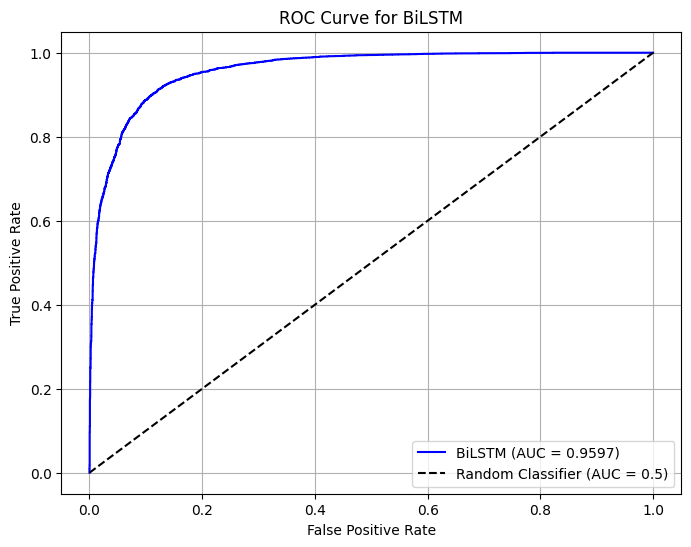

In [18]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'BiLSTM (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')
plt.title('ROC Curve for BiLSTM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
review = """What this movie does well is the fight sequences where
Statham dispenses justice. At those moments, it’s exciting, visceral,
and thrilling. What this movie doesn’t do well is… everything else."""

sentiment, confidence = predict_custom(review)
print(f"Prediction: {sentiment} | Confidence: {confidence:.4f}")

review = """Zegler is the film’s only saving grace, bringing warmth, strength,
and sincerity to a script that doesn’t deserve her."""

sentiment, confidence = predict_custom(review)
print(f"Prediction: {sentiment} | Confidence: {confidence:.4f}")

Prediction: Positive | Confidence: 0.9616
Prediction: Negative | Confidence: 0.2191
